In [140]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator, MultipleLocator
import netCDF4 as nc4

# https://mpl-point-clicker.readthedocs.io/en/latest/
from mpl_point_clicker import clicker
from mpl_interactions import zoom_factory, panhandler

with open('mbathy.npy', 'rb') as f:
    mbath = np.load(f,allow_pickle=True)
    
with open('mbathy_mask.npy', 'rb') as f:
    mmask = np.load(f,allow_pickle=True)

bath =np.ma.masked_where(mmask==1,mbath)

# twilight, gnuplot, gist_heat, hsv
palette = plt.get_cmap("YlGnBu",75)
kwargs_colorbar = dict(orientation="horizontal",shrink=0.8, 
                       location='bottom',aspect = 60, fraction=0.05,pad = 0.1)

""" Z discrete
"""
pmm = "../../eORCA1.4.2_ModifStraits_mesh_mask.nc"
mm = nc4.Dataset(pmm)
e3t_1d = mm.variables['e3t_1d'][0] ; e3w_1d = mm.variables['e3w_1d'][0]
nK = len(e3t_1d)

dept_1d    = np.zeros((nK))  ; depw_1d = np.zeros((nK)) 
dept_1d[0] = 0.5 * e3w_1d[0]
for k in range(1,nK):
    depw_1d[k] = depw_1d[k-1] + e3t_1d[k-1]
    dept_1d[k] = dept_1d[k-1] + e3w_1d[k-1]

---
---
## Worldwide map

<IPython.core.display.Javascript object>


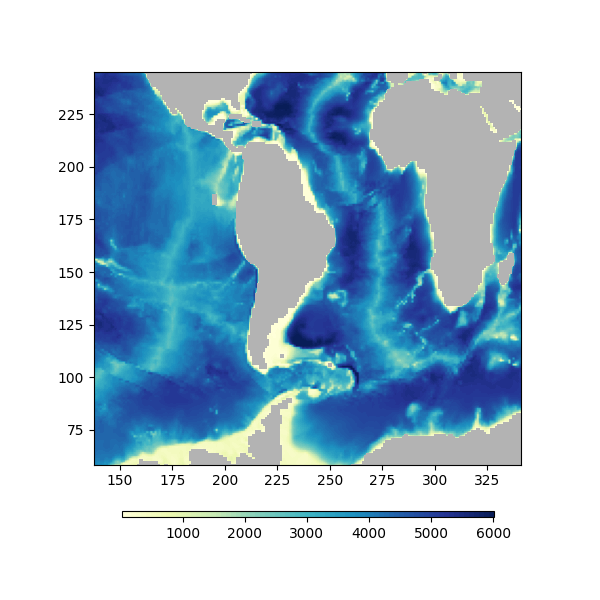

In [141]:
#%matplotlib inline
%matplotlib notebook
fig, ax = plt.subplots(figsize=(6,6))
cf = plt.imshow(bath, cmap=palette)
ax.invert_yaxis()
fig.colorbar(cf,**kwargs_colorbar)
zoom_factory(ax)
ax.set_aspect(aspect='equal')
ax.patch.set_color('0.7')
plt.show()

## Compare

<IPython.core.display.Javascript object>


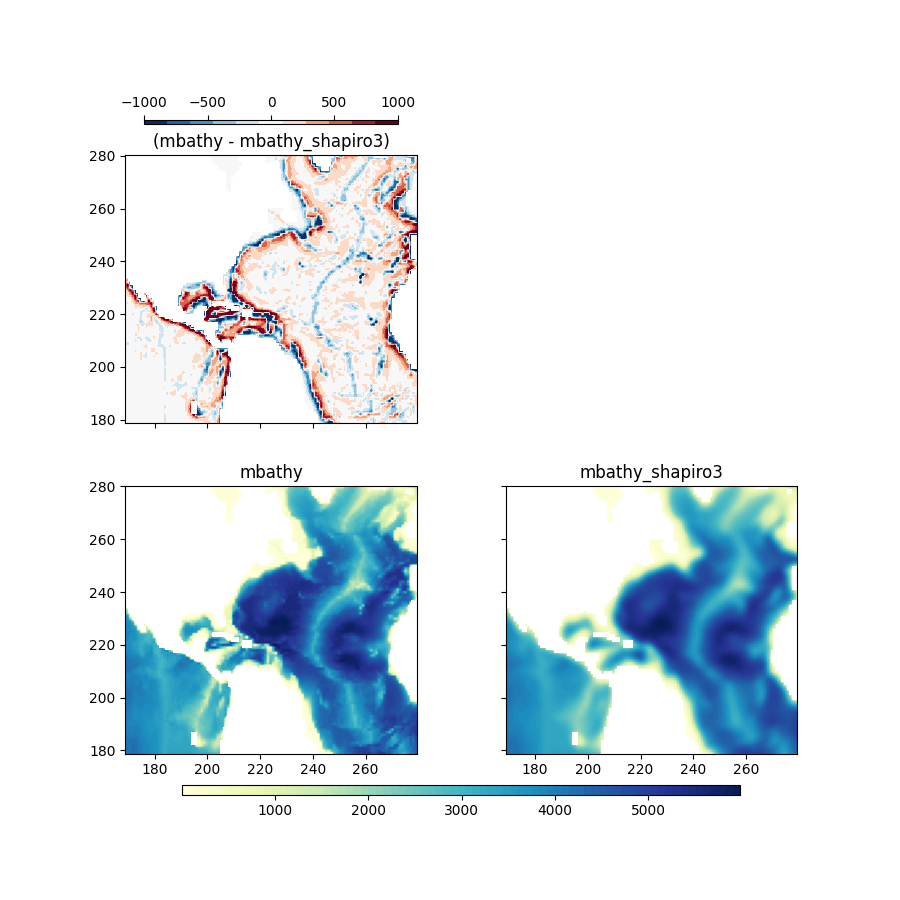

In [147]:
pname1 = "mbathy.npy"
pname2 = "mbathy_shapiro3.npy"

with open('mbathy_mask.npy', 'rb') as f:
    mmask = np.load(f,allow_pickle=True)
with open( pname1, 'rb') as f:
    bath1 = np.load(f,allow_pickle=True)
with open( pname2, 'rb') as f:
    bath2 = np.load(f,allow_pickle=True)

%matplotlib notebook
diffett = plt.get_cmap("RdBu_r",11)
data1 =np.ma.masked_where(mmask==1,bath1)
data2 =np.ma.masked_where(mmask==1,bath2)
data3 =np.ma.masked_where(mmask==1,bath1 - bath2)
    
fig, ax = plt.subplots(2,2,figsize=(9,9),sharex=True, sharey=True)
a1 = ax[1,0].imshow(data1, cmap = palette)
a2 = ax[1,1].imshow(data2, cmap = palette)
a3 = ax[0,0].imshow(data3, cmap = diffett ,vmin=-1000,vmax=1000)
ax[0,0].invert_yaxis() # shared axis
ax[0,1].axis('off')

fig.colorbar(a2, ax=ax[1,:],shrink=0.8, location='bottom',aspect = 60, fraction=0.05,pad = 0.1)
fig.colorbar(a3, ax=ax[0,0],shrink=0.8, location='top'   ,aspect = 60, fraction=0.05,pad = 0.1)

ax[1,0].set_title(pname1.split('.')[0])
ax[1,1].set_title(pname2.split('.')[0])
ax[0,0].set_title("(%s - %s)" % (pname1.split('.')[0],
                                       pname2.split('.')[0]))

for a,b in [[0,0],[1,0],[1,1]] :
    zoom_factory(ax[a,b])
#plt.subplots_adjust(bottom=0.5, right=0.8, top=0.1)
#fig.tight_layout()

---
---
## Section

In [118]:
def partialstep(data,n=0):
    nJ,nI=np.shape(data) ; nK = len(e3t_1d)
    """ bottom level
    """
    databot = np.zeros((nJ,nI),dtype=int) # indice dernier T-niveau mouillé (en FORTRAN 1->jpk)
    databot[:,:] = nK -1    # jpkm1 (FORTRAN)
    for k in range(nK-1,-1,-1):
        ze3min = 0.1 * e3t_1d[k]
        b,a=np.where( data <  depw_1d[k] + ze3min )
        databot[b,a] = k-1 +1 # (k-1)(FOR) +1(PYT) -> read for NEMO (1->jpk - 0 pour continent)
    """ Partial/Full Step à la NEMO
    """
    if n == 1 : # partial steps
        print("partial steps")
        e3wp = np.zeros((nK,nJ,nI)) ; e3tp = np.zeros((nK,nJ,nI)) ; datameter = np.zeros((nJ,nI))
        for j in range(nJ):
            for i in range(nI):
                e3wp[:,j,i] = e3w_1d[:]
                e3tp[:,j,i] = e3t_1d[:]
                k0 = databot[j,i] -1 #-1 (for python)
                if k0>0:
                    e3tp[k0,j,i] = data[j,i] - depw_1d[k0] # garde les plus grosses cellules
                    e3wp[k0,j,i] = 0.5 * (e3tp[k0-1,j,i] + e3tp[k0,j,i])
                    # 
                    #e3tp[k0+1,j,i] = e3tp[k0,j,i] 
                    #e3wp[k0+1,j,i] = e3tp[k0,j,i] 
                datameter[j,i] = np.sum(e3tp[:k0+1,j,i])
    elif (n==0):
        print("full steps")
        e3wp = np.zeros((nK,nJ,nI)) ; e3tp = np.zeros((nK,nJ,nI)) ; datameter = np.zeros((nJ,nI))
        for j in range(nJ):
            for i in range(nI):
                k0 = databot[j,i] -1 #-1 (for python)
                datameter[j,i] = np.sum(e3t_1d[:k0+1+1]) #+1(slice)+1(fullstep) 
        databot+=1
    del e3wp,e3tp
    return(datameter,databot)


In [149]:
pname1 = "mbathy.npy"
pname2 = "mbathy_shapiro3.npy"

with open( pname1, 'rb') as f:
    bath1 = np.load(f,allow_pickle=True)
with open( pname2, 'rb') as f:
    bath2 = np.load(f,allow_pickle=True)
    
datameter1,databot1 = partialstep(bath1,n=0)
datameter2,databot2 = partialstep(bath2,n=0)

full steps
full steps


In [68]:
pname1 = "mbathy.npy"
pname2 = "mbathy_shapiro1.npy"

with open( pname1, 'rb') as f:
    datameter1 = np.load(f,allow_pickle=True)
with open( pname2, 'rb') as f:
    datameter2 = np.load(f,allow_pickle=True)

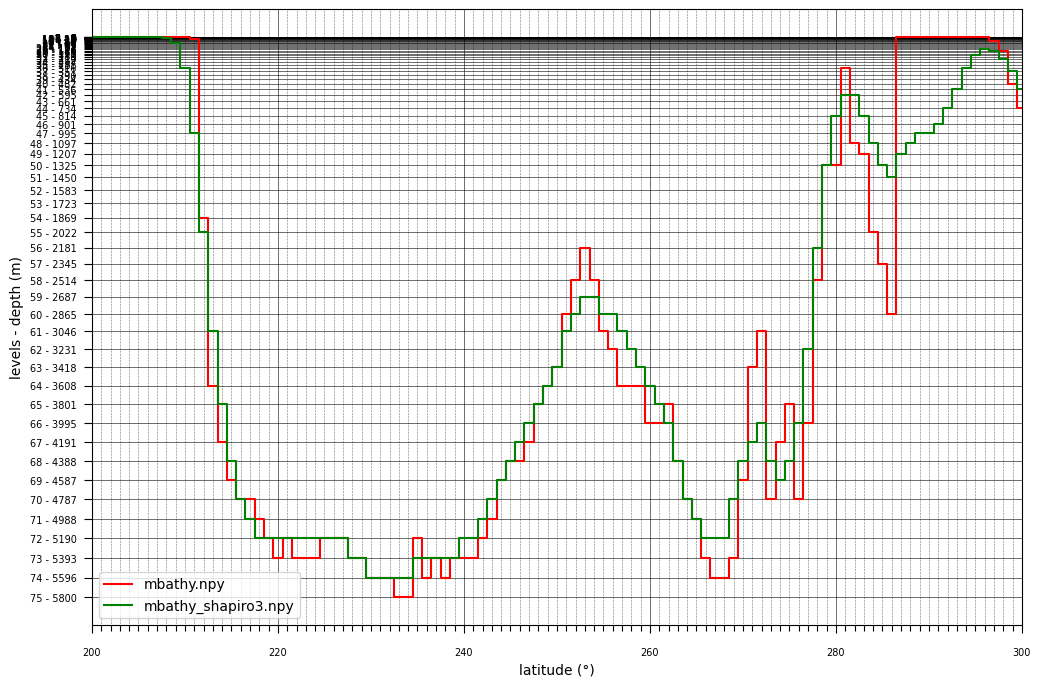

In [150]:
#lonx = np.arange(240,301) ; lat = 139 # Faille de Vema
lonx = np.arange(200,301) ; lat = 240 # GS
section1 = datameter1[lat,lonx]
section2 = datameter2[lat,lonx]

jpk1 = databot1[lat,lonx]
jpk2 = databot2[lat,lonx]

%matplotlib inline
#%matplotlib notebook
fig, ax = plt.subplots(figsize=(12,8))
plt.step(lonx,section1,label = "%s" % pname1, where='mid',color="red")
plt.step(lonx,section2,label = "%s" % pname2, where='mid',color="green")

ax.set_xlim(lonx[0],lonx[-1])
ax.set_xlabel("latitude (°)")

ax.invert_yaxis()
ax.set_yticks(depw_1d,['%d - %d' % (k+1,depw_1d[k]) for k in range(nK)])
ax.set_ylabel("levels - depth (m)")
ax.legend()
ax.grid(which='major', linestyle='-', linewidth=0.4, color='black')
ax.grid(which='minor', linestyle=':', linewidth=0.4, color='black')
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.tick_params(axis = "y", which = 'both', width=0.8, labelsize = 7, pad = 5)
ax.tick_params(axis = 'x', which = 'both', width=0.8, labelsize = 7, pad = 10)
ax.tick_params(which='minor',length = 4)
ax.tick_params(which='major',length = 6)
plt.show()

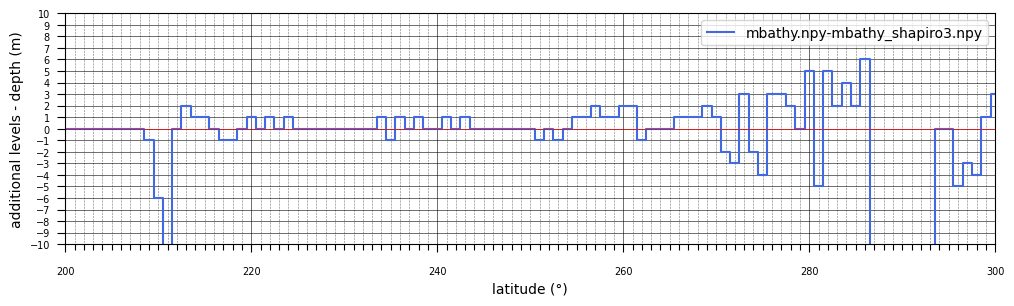

In [148]:
%matplotlib inline
#%matplotlib notebook
y1 = 10


fig, ax = plt.subplots(figsize=(12,3))
plt.step(lonx,jpk1 - jpk2,label = "%s-%s" % (pname1,pname2), where='mid',color="royalblue")
plt.axhline(y = 0, color = 'r', linestyle = '-',linewidth=0.5)
ax.set_xlim(lonx[0],lonx[-1])
ax.set_xlabel("latitude (°)")
ax.invert_yaxis()
ax.set_ylim(-y1,y1)
ax.set_yticks(np.arange(-y1,y1+1,1))
ax.set_ylabel("additional levels - depth (m)")
ax.legend()
ax.grid(which='major', linestyle='-', linewidth=0.4, color='black')
ax.grid(which='minor', linestyle=':', linewidth=0.4, color='black')
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.tick_params(axis = "y", which = 'both', width=0.8, labelsize = 7, pad = 5)
ax.tick_params(axis = 'x', which = 'both', width=0.8, labelsize = 7, pad = 10)
ax.tick_params(which='minor',length = 4)
ax.tick_params(which='major',length = 6)
plt.show()

---
---
## Partial steps

In [65]:
def partialstep(data):
    nJ,nI=np.shape(data) ; nK = len(e3t_1d)
    """ bottom level
    """
    databot = np.zeros((nJ,nI),dtype=int) # indice dernier T-niveau mouillé (en FORTRAN 1->jpk)
    databot[:,:] = nK -1    # jpkm1 (FORTRAN)
    for k in range(nK-1,-1,-1):
        ze3min = 0.1 * e3t_1d[k]
        b,a=np.where( data <  depw_1d[k] + ze3min )
        databot[b,a] = k-1 +1 # (k-1)(FOR) +1(PYT) -> read for NEMO (1->jpk - 0 pour continent)
    """ Partial Step à la NEMO
    """
    e3wp = np.zeros((nK,nJ,nI)) ; e3tp = np.zeros((nK,nJ,nI)) ; datameter = np.zeros((nJ,nI))
    for j in range(nJ):
        for i in range(nI):
            e3wp[:,j,i] = e3w_1d[:]
            e3tp[:,j,i] = e3t_1d[:]
            k0 = databot[j,i] -1 #-1 (for python)
            if k0>0:
                e3tp[k0,j,i] = data[j,i] - depw_1d[k0] # garde les plus grosses cellules
                e3wp[k0,j,i] = 0.5 * (e3tp[k0-1,j,i] + e3tp[k0,j,i])
                # 
                #e3tp[k0+1,j,i] = e3tp[k0,j,i] 
                #e3wp[k0+1,j,i] = e3tp[k0,j,i] 
            datameter[j,i] = np.sum(e3wp[:k0+1,j,i])
    del e3wp,e3tp
    return(datameter)


---
---
---
# Useful

In [ ]:
nJ,nI=np.shape(bath1) ; nK = len(e3t_1d)

""" bottom level
"""
bath1bot = np.zeros((nJ,nI),dtype=int) # indice dernier T-niveau mouillé (en FORTRAN 1->jpk)
bath1bot[:,:] = nK -1    # jpkm1 (FORTRAN)

for k in range(nK-1,-1,-1):
    ze3min = 0.1 * e3t_1d[k]
    b,a=np.where( bath1 <  depw_1d[k] + ze3min )
    bath1bot[b,a] = k-1 +1 # (k-1)(FOR) +1(PYT) -> read for NEMO (1->jpk - 0 pour continent)

""" Partial Step à la NEMO
"""
e3wp = np.zeros((nK,nJ,nI)) ; e3tp = np.zeros((nK,nJ,nI)) ; bath1meter = np.zeros((nJ,nI))
for j in range(nJ):
    for i in range(nI):
        e3wp[:,j,i] = e3w_1d[:]
        e3tp[:,j,i] = e3t_1d[:]
        k0 = bath1bot[j,i] -1 #-1 (for python)
        if k0>0:
            e3tp[k0,j,i] = bath1[j,i] - depw_1d[k0] # garde les plus grosses cellules
            e3wp[k0,j,i] = 0.5 * (e3tp[k0-1,j,i] + e3tp[k0,j,i])
            # 
            #e3tp[k0+1,j,i] = e3tp[k0,j,i] 
            #e3wp[k0+1,j,i] = e3tp[k0,j,i] 
        bath1meter[j,i] = np.sum(e3wp[:k0+1,j,i])


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

#def add_subplot_axes(ax,rect,facecolor='w'): # matplotlib 2.0+
def add_subplot_axes(ax,rect,axisbg='w'):
    fig = plt.gcf()
    box = ax.get_position()
    width = box.width
    height = box.height
    inax_position  = ax.transAxes.transform(rect[0:2])
    transFigure = fig.transFigure.inverted()
    infig_position = transFigure.transform(inax_position)    
    x = infig_position[0]
    y = infig_position[1]
    width *= rect[2]
    height *= rect[3]  # <= Typo was here
    #subax = fig.add_axes([x,y,width,height],facecolor=facecolor)  # matplotlib 2.0+
    subax = fig.add_axes([x,y,width,height],axisbg=axisbg)
    x_labelsize = subax.get_xticklabels()[0].get_size()
    y_labelsize = subax.get_yticklabels()[0].get_size()
    x_labelsize *= rect[2]**0.5
    y_labelsize *= rect[3]**0.5
    subax.xaxis.set_tick_params(labelsize=x_labelsize)
    subax.yaxis.set_tick_params(labelsize=y_labelsize)
    return subax
    
def example1():
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    rect = [0.2,0.2,0.7,0.7]
    ax1 = add_subplot_axes(ax,rect)
    ax2 = add_subplot_axes(ax1,rect)
    ax3 = add_subplot_axes(ax2,rect)
    plt.show()

def example2():
    fig = plt.figure(figsize=(10,10))
    axes = []
    subpos = [0.2,0.6,0.3,0.3]
    x = np.linspace(-np.pi,np.pi)
    for i in range(4):
        axes.append(fig.add_subplot(2,2,i))
    for axis in axes:
        axis.set_xlim(-np.pi,np.pi)
        axis.set_ylim(-1,3)
        axis.plot(x,np.sin(x))
        subax1 = add_subplot_axes(axis,subpos)
        subax2 = add_subplot_axes(subax1,subpos)
        subax1.plot(x,np.sin(x))
        subax2.plot(x,np.sin(x))
if __name__ == '__main__':
    example2()
    plt.show()